In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import svm

In [6]:
data = pd.read_excel('Dataset.xlsx', engine='openpyxl')
data.head()

,Team,Match Up,Game Date,W/L,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF,+/-
0,GSW,GSW vs. PHX,10/24/2023,L,240,104,36,101,35.6,10,...,78.6,18,31,49,19,11,6,11,23,-4
1,PHX,PHX @ GSW,10/24/2023,W,240,108,42,95,44.2,11,...,76.5,17,43,60,23,5,7,19,22,4
2,LAL,LAL @ DEN,10/24/2023,L,240,107,41,90,45.6,10,...,75,13,31,44,23,5,4,12,18,-12
3,DEN,DEN vs. LAL,10/24/2023,W,240,119,48,91,52.7,14,...,75,9,33,42,29,9,6,12,15,12
4,MEM,MEM vs. NOP,10/25/2023,L,240,104,38,91,41.8,12,...,80,8,29,37,23,8,7,13,19,-7


In [10]:
def Weighting_fun(L, alpha=0.5):
    Res = [alpha ** i for i in np.arange(L, 0, -1)]
    Res /= np.sum(Res)
    return Res

In [91]:
Home = []
for i in range(data.shape[0]):
    if data.iloc[:, 1][i][4:6]=='vs':
        Home.append(1)
    if data.iloc[:,1][i][4:6]=='@ ':
        Home.append(0)
data['home'] = np.array(Home)
data.loc[data['W/L'] == 'W', 'W/L'] = 1
data.loc[data['W/L'] == 'L', 'W/L'] = 0
data.loc[data['FT%']=='-','FT%'] = 1


Features = ['W/L','PTS', 'FGM', 'FGA',
       'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-']
for i in Features:
    data[i] = data[i].astype(float)

X_all = []
Y_all = []

The code below is professors baseline

In [86]:
for i in np.arange(300,data.shape[0]):
    Team_1 = data.iloc[i,0]
    Team_2 = data.iloc[i,1][-3::]
    Data_Previous_1 = (data.iloc[0:i,:][data.iloc[0:i,0]==Team_1])
    Data_Previous_2 = (data.iloc[0:i,:][data.iloc[0:i,0]==Team_2])
    Data_Previous_1_home = np.array(Data_Previous_1[Data_Previous_1['home'] == data.iloc[i, -1]][Features])
    Data_Previous_2_home = np.array(Data_Previous_2[Data_Previous_2['home'] == (1-data.iloc[i, -1])][Features])
    W1 = Weighting_fun(Data_Previous_1_home.shape[0],0.4).reshape(-1,1)
    W2 = Weighting_fun(Data_Previous_2_home.shape[0],0.4).reshape(-1,1)
    Data_1 = np.array(Data_Previous_1_home[:,3::] * W1).mean(axis=0)
    Data_2 = np.array(Data_Previous_2_home[:,3::] * W2).mean(axis=0)
    Diff = (Data_1 - Data_2).tolist() + [data.iloc[i,-1]]
    X_all.append(Diff)
    Y_all.append(data.iloc[i]['W/L'])

X = np.array(X_all)
y = np.array(Y_all)

The code below is the dataset after adding stability features.

In [88]:
for i in np.arange(300, data.shape[0]):
    Team_1 = data.iloc[i, 0]
    Team_2 = data.iloc[i, 1][-3::]
    
    # Extract historical data from both teams
    Data_Previous_1 = data.iloc[0:i, :][data.iloc[0:i, 0] == Team_1]
    Data_Previous_2 = data.iloc[0:i, :][data.iloc[0:i, 0] == Team_2]
    
    # Filter historical data based on teams
    Data_Previous_1_home = np.array(Data_Previous_1[Data_Previous_1['home'] == data.iloc[i, -1]][Features])
    Data_Previous_2_home = np.array(Data_Previous_2[Data_Previous_2['home'] == (1 - data.iloc[i, -1])][Features])
    
    # calculat weight
    W1 = Weighting_fun(Data_Previous_1_home.shape[0], 0.4).reshape(-1, 1)
    W2 = Weighting_fun(Data_Previous_2_home.shape[0], 0.4).reshape(-1, 1)
    
    # Weighted mean
    Data_1_mean = np.array(Data_Previous_1_home[:, 3:] * W1).mean(axis=0)
    Data_2_mean = np.array(Data_Previous_2_home[:, 3:] * W2).mean(axis=0)
    
    # Weighted variance
    Data_1_var = np.array(Data_Previous_1_home[:, 3:] * W1).var(axis=0)
    Data_2_var = np.array(Data_Previous_2_home[:, 3:] * W2).var(axis=0)
    
    # Stability
    Stability_1 = Data_1_mean / (Data_1_var + 1e-8)
    Stability_2 = Data_2_mean / (Data_2_var + 1e-8)
    
    Stability_Score_1 = Stability_1.mean()
    Stability_Score_2 = Stability_2.mean()
    
    # Calculate the stability difference
    Stability_Diff = Stability_Score_1 - Stability_Score_2
    
    # Original features difference
    Diff = (Data_1_mean - Data_2_mean).tolist() + [data.iloc[i, -1]]
    Diff.append(Stability_Diff)
    
    X_all.append(Diff)
    Y_all.append(data.iloc[i]['W/L'])

X = np.array(X_all)
print(X[:5])
y = np.array(Y_all)

[[ 3.71795071  0.99393912 -0.12170007  1.48127229 -0.96566614 -1.83129038
  -1.18116736 -1.60401305  0.35051774  1.11291302  1.46343076  1.96029472
  -0.58010187  0.11416721  0.05711766 -0.12807522 -5.54128875  0.
   0.17629707]
 [ 2.44991083  2.41805952  0.19236001 -0.53378232  2.2277172   0.05429696
   0.51752109  0.7712043   0.1681683   2.11599532  2.28416362  1.41439653
  -0.05810464  0.17953651  0.43680564  0.83202257 -0.93197016  1.
   0.02204719]
 [-6.59160335 -4.54052915 -1.19222626 -3.91995628 -2.337292   -1.90660726
  -3.3029263  -3.87551388  0.76091644 -1.3865804  -0.62566396 -3.38380545
  -0.69827919 -0.3508434  -0.41720182 -3.24864438  2.55029151  1.
  -0.01458255]
 [-0.79606066  1.46107898  0.53611593 -0.15333205  1.99644946  2.88175567
   2.61001864  4.12244072 -0.20413213  0.12071846 -0.08341366 -0.36029176
   0.42776814  0.13707345 -0.93872502  1.50125313  6.18867682  1.
  -0.08006846]
 [-7.60281617 -3.70423356 -1.84664025 -3.75588341 -4.19221385 -2.53128899
  -3.55851

All features: weighted, stability, home advantage, previous competition

In [ ]:
for i in np.arange(300, data.shape[0]):
    Team_1 = data.iloc[i, 0]
    Team_2 = data.iloc[i, 1][-3::]
    
    Data_Previous_1 = data.iloc[0:i, :][data.iloc[0:i, 0] == Team_1]
    Data_Previous_2 = data.iloc[0:i, :][data.iloc[0:i, 0] == Team_2]
    
    Data_Previous_1_home = np.array(Data_Previous_1[Data_Previous_1['home'] == data.iloc[i, -1]][Features])
    Data_Previous_2_home = np.array(Data_Previous_2[Data_Previous_2['home'] == (1 - data.iloc[i, -1])][Features])
    
    W1 = Weighting_fun(Data_Previous_1_home.shape[0], 0.4).reshape(-1, 1)
    W2 = Weighting_fun(Data_Previous_2_home.shape[0], 0.4).reshape(-1, 1)
    
    Data_1_mean = np.array(Data_Previous_1_home[:, 3:] * W1).mean(axis=0)
    Data_2_mean = np.array(Data_Previous_2_home[:, 3:] * W2).mean(axis=0)
    
    Data_1_var = np.array(Data_Previous_1_home[:, 3:] * W1).var(axis=0)
    Data_2_var = np.array(Data_Previous_2_home[:, 3:] * W2).var(axis=0)
    
    Stability_1 = Data_1_mean / (Data_1_var + 1e-8)
    Stability_2 = Data_2_mean / (Data_2_var + 1e-8)
    
    Stability_Score_1 = Stability_1.mean()
    Stability_Score_2 = Stability_2.mean()
    
    Stability_Diff = Stability_Score_1 - Stability_Score_2
    
    # Calculate the characteristics of Previous Competitions
    # Find the history of matches between two teams
    Direct_Competitions = data.iloc[0:i, :][
        ((data.iloc[0:i, 0] == Team_1) & (data.iloc[0:i, 1].str[-3:] == Team_2)) |
        ((data.iloc[0:i, 0] == Team_2) & (data.iloc[0:i, 1].str[-3:] == Team_1))
    ]
    
    # Count the number and total number of Team_1 wins
    if not Direct_Competitions.empty:
        Team_1_Wins = sum(
            (Direct_Competitions['W/L'] == 1) &
            (Direct_Competitions.iloc[:, 0] == Team_1)
        )
        Team_2_Wins = sum(
            (Direct_Competitions['W/L'] == 1) &
            (Direct_Competitions.iloc[:, 0] == Team_2)
        )
        Previous_Competitions_Score = Team_1_Wins - Team_2_Wins
    else:
        Previous_Competitions_Score = 0  # If there is no historical match record, the value is 0
    
    Diff = (Data_1_mean - Data_2_mean).tolist() + [data.iloc[i, -1]]
    
    Diff.append(Stability_Diff)
    Diff.append(Previous_Competitions_Score)
    
    X_all.append(Diff)
    Y_all.append(data.iloc[i]['W/L'])

X = np.array(X_all)
print(X[:5])
y = np.array(Y_all)

[[ 3.71795071  0.99393912 -0.12170007  1.48127229 -0.96566614 -1.83129038
  -1.18116736 -1.60401305  0.35051774  1.11291302  1.46343076  1.96029472
  -0.58010187  0.11416721  0.05711766 -0.12807522 -5.54128875  0.
   0.17629707  0.        ]
 [ 2.44991083  2.41805952  0.19236001 -0.53378232  2.2277172   0.05429696
   0.51752109  0.7712043   0.1681683   2.11599532  2.28416362  1.41439653
  -0.05810464  0.17953651  0.43680564  0.83202257 -0.93197016  1.
   0.02204719 -1.        ]
 [-6.59160335 -4.54052915 -1.19222626 -3.91995628 -2.337292   -1.90660726
  -3.3029263  -3.87551388  0.76091644 -1.3865804  -0.62566396 -3.38380545
  -0.69827919 -0.3508434  -0.41720182 -3.24864438  2.55029151  1.
  -0.01458255  0.        ]
 [-0.79606066  1.46107898  0.53611593 -0.15333205  1.99644946  2.88175567
   2.61001864  4.12244072 -0.20413213  0.12071846 -0.08341366 -0.36029176
   0.42776814  0.13707345 -0.93872502  1.50125313  6.18867682  1.
  -0.08006846  0.        ]
 [-7.60281617 -3.70423356 -1.8466402

In [93]:
X = pd.DataFrame(X)
y = pd.Series(y)
# Step 1: Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)  # Standardize X to have zero mean and unit variance

# Step 2: Fit Logistic Regression with L1 regularization for binary model
lasso_log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)  # L1 penalty for feature selection
lasso_log_reg.fit(X_standardized, y)

# Step 3: Identify selected features
selected_features = X.columns[(lasso_log_reg.coef_ != 0).flatten()]  # Keep only features with non-zero coefficients
X_selected = X[selected_features]  # Subset original X with selected features

print(f"Selected features: {list(selected_features)}")
X_selected.head()

Selected features: [0, 1, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


,0,1,3,4,5,6,9,10,11,12,13,14,15,16,17,18,19
0,3.717951,0.993939,1.481272,-0.965666,-1.831290,-1.181167,1.112913,1.463431,1.960295,-0.580102,0.114167,0.057118,-0.128075,-5.541289,0.0,0.176297,0.0
1,2.449911,2.418060,-0.533782,2.227717,0.054297,0.517521,2.115995,2.284164,1.414397,-0.058105,0.179537,0.436806,0.832023,-0.931970,1.0,0.022047,-1.0
2,-6.591603,-4.540529,-3.919956,-2.337292,-1.906607,-3.302926,-1.386580,-0.625664,-3.383805,-0.698279,-0.350843,-0.417202,-3.248644,2.550292,1.0,-0.014583,0.0
3,-0.796061,1.461079,-0.153332,1.996449,2.881756,2.610019,0.120718,-0.083414,-0.360292,0.427768,0.137073,-0.938725,1.501253,6.188677,1.0,-0.080068,0.0
4,-7.602816,-3.704234,-3.755883,-4.192214,-2.531289,-3.558516,-3.500366,-5.663095,-2.669701,-1.210358,-0.191737,-2.089562,-2.173723,-1.672848,0.0,0.048534,0.0


In [84]:
def z_score_normalize(df):
    return (df - df.mean()) / df.std()

In [107]:
# normalized X
X_normalized = z_score_normalize(X_selected)

X = pd.DataFrame(X_normalized)
y = pd.Series(y)

# Ensure data is shuffled before splitting
# X_shuffled, y_shuffled = shuffle(X, y, random_state=1)
X_shuffled, y_shuffled = X, y
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=0),
    'Logistic Regression': LogisticRegression(random_state=0, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=0),
    'AdaBoost': AdaBoostClassifier(random_state=0),
    #'QDA': QuadraticDiscriminantAnalysis(),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=0),
    'Kernel SVM': SVC(kernel='rbf', random_state=0),
    'Linear SVM': SVC(kernel='linear', random_state=0)  # Add kernel SVM
}

# Initialize K-Fold with shuffle
kf = KFold(n_splits=5, shuffle=True, random_state=406)

# Store accuracies for each model
model_accuracies = {model_name: [] for model_name in models}

for train_index, test_index in kf.split(X_shuffled):
    # Split the data into training and testing sets
    X_train, X_test = X_shuffled.iloc[train_index], X_shuffled.iloc[test_index]
    y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]
    
    for model_name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        model_accuracies[model_name].append(accuracy)

# Print results
for model_name, accuracies in model_accuracies.items():
    print(f"{model_name} Accuracy for each fold: {accuracies}")
    print(f"{model_name} Mean accuracy: {sum(accuracies) / len(accuracies):.2f}")

Random Forest Accuracy for each fold: [0.6944444444444444, 0.7013888888888888, 0.7060185185185185, 0.7129629629629629, 0.6689814814814815]
Random Forest Mean accuracy: 0.70
Logistic Regression Accuracy for each fold: [0.6851851851851852, 0.7314814814814815, 0.6851851851851852, 0.7199074074074074, 0.6597222222222222]
Logistic Regression Mean accuracy: 0.70
Decision Tree Accuracy for each fold: [0.6018518518518519, 0.5902777777777778, 0.6111111111111112, 0.6018518518518519, 0.5925925925925926]
Decision Tree Mean accuracy: 0.60
AdaBoost Accuracy for each fold: [0.6712962962962963, 0.7291666666666666, 0.6828703703703703, 0.7013888888888888, 0.6342592592592593]
AdaBoost Mean accuracy: 0.68
XGBoost Accuracy for each fold: [0.6504629629629629, 0.6782407407407407, 0.6759259259259259, 0.6759259259259259, 0.6527777777777778]
XGBoost Mean accuracy: 0.67
Kernel SVM Accuracy for each fold: [0.6666666666666666, 0.7337962962962963, 0.6990740740740741, 0.7083333333333334, 0.6666666666666666]
Kernel SV

Here are the professors training methods code:

In [95]:
from sklearn import svm
X_train, X_test = X.iloc[0:1500, :], X.iloc[1500:, :]
y_train, y_test = y.iloc[0:1500], y.iloc[1500:]
model = svm.SVC()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print(accuracy)

0.696969696969697


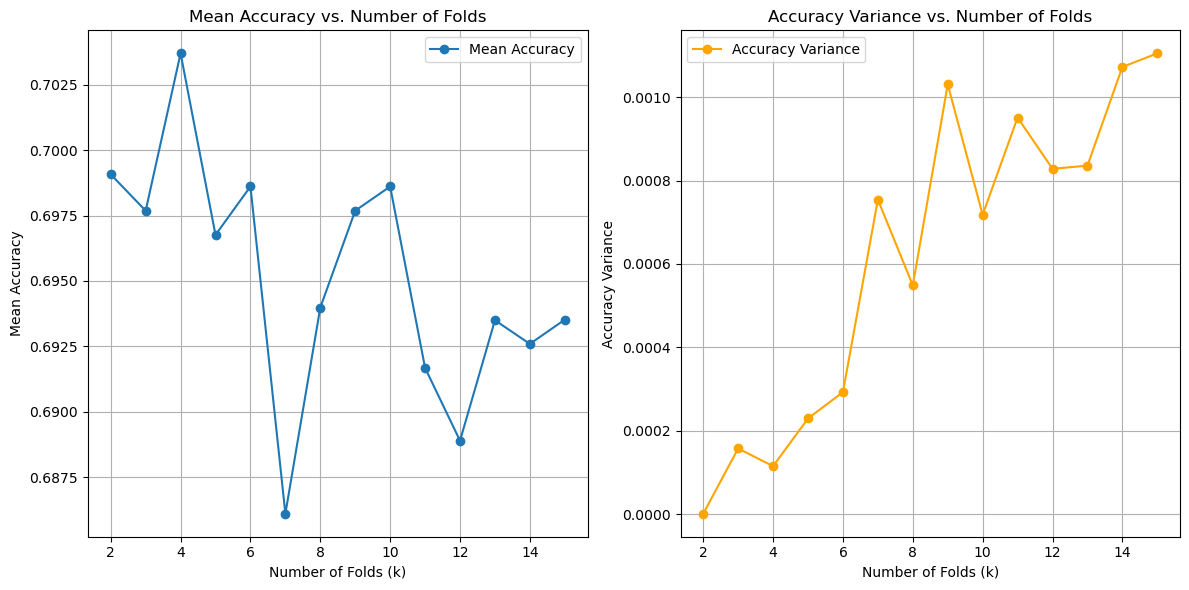

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# Range of k values to test
k_values = range(2, 16)  # Testing k from 2 to 15

# Dictionary to store mean accuracy and variance for each k
k_results = {'k': [], 'mean_accuracy': [], 'accuracy_variance': []}

for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=406)
    model = RandomForestClassifier(random_state=0)  # Example model (can switch to others)
    fold_accuracies = []
    
    for train_index, test_index in kf.split(X_shuffled):
        # Split the data into training and testing sets
        X_train, X_test = X_shuffled.iloc[train_index], X_shuffled.iloc[test_index]
        y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        fold_accuracies.append(accuracy_score(y_test, y_pred))
    
    # Record results for current k
    k_results['k'].append(k)
    k_results['mean_accuracy'].append(np.mean(fold_accuracies))
    k_results['accuracy_variance'].append(np.var(fold_accuracies))

# Plot mean accuracy and variance for different k values
plt.figure(figsize=(12, 6))

# Mean accuracy plot
plt.subplot(1, 2, 1)
plt.plot(k_results['k'], k_results['mean_accuracy'], marker='o', label='Mean Accuracy')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs. Number of Folds')
plt.grid(True)
plt.legend()

# Accuracy variance plot
plt.subplot(1, 2, 2)
plt.plot(k_results['k'], k_results['accuracy_variance'], marker='o', label='Accuracy Variance', color='orange')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Accuracy Variance')
plt.title('Accuracy Variance vs. Number of Folds')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


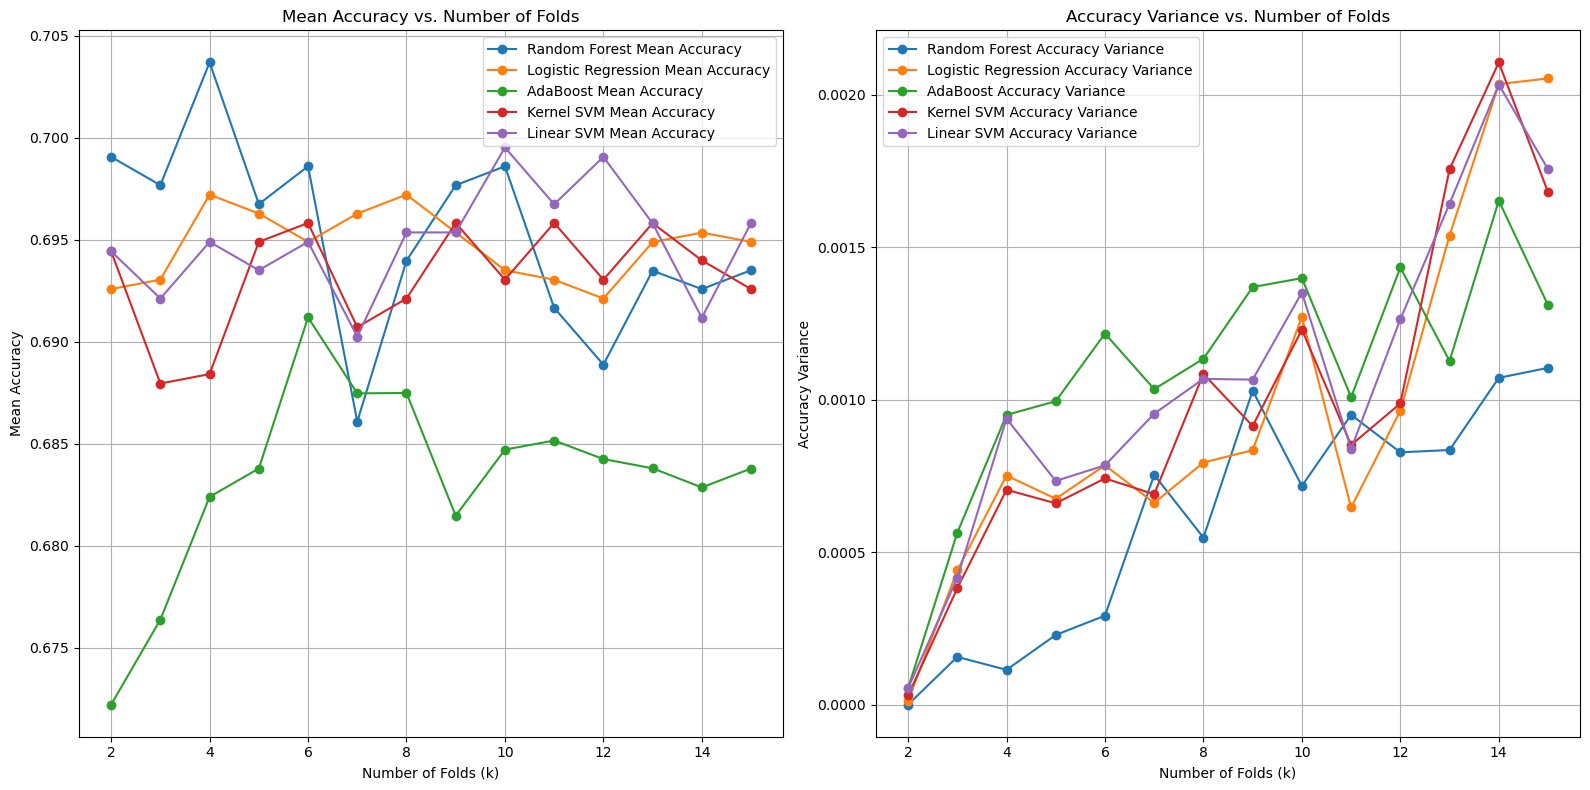

In [103]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Range of k values to test
k_values = range(2, 16)  # Testing k from 2 to 15

# Models to evaluate
models = {
    'Random Forest': RandomForestClassifier(random_state=0),
    'Logistic Regression': LogisticRegression(random_state=0, max_iter=1000),
    'AdaBoost': AdaBoostClassifier(random_state=0),
    'Kernel SVM': SVC(kernel='rbf', random_state=0),
    'Linear SVM': SVC(kernel='linear', random_state=0)
}

# Dictionary to store results for each model
model_results = {model_name: {'k': [], 'mean_accuracy': [], 'accuracy_variance': []} for model_name in models}

for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=406)
    
    for model_name, model in models.items():
        fold_accuracies = []
        
        for train_index, test_index in kf.split(X_shuffled):
            # Split the data into training and testing sets
            X_train, X_test = X_shuffled.iloc[train_index], X_shuffled.iloc[test_index]
            y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]
            
            # Fit the model
            model.fit(X_train, y_train)
            
            # Predict on the test set
            y_pred = model.predict(X_test)
            
            # Calculate accuracy
            fold_accuracies.append(accuracy_score(y_test, y_pred))
        
        # Record results for current k
        model_results[model_name]['k'].append(k)
        model_results[model_name]['mean_accuracy'].append(np.mean(fold_accuracies))
        model_results[model_name]['accuracy_variance'].append(np.var(fold_accuracies))

# Plot mean accuracy and variance for different k values
plt.figure(figsize=(16, 8))

# Mean accuracy plot
plt.subplot(1, 2, 1)
for model_name in models:
    plt.plot(
        model_results[model_name]['k'],
        model_results[model_name]['mean_accuracy'],
        marker='o',
        label=f'{model_name} Mean Accuracy'
    )
plt.xlabel('Number of Folds (k)')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs. Number of Folds')
plt.grid(True)
plt.legend()

# Accuracy variance plot
plt.subplot(1, 2, 2)
for model_name in models:
    plt.plot(
        model_results[model_name]['k'],
        model_results[model_name]['accuracy_variance'],
        marker='o',
        label=f'{model_name} Accuracy Variance'
    )
plt.xlabel('Number of Folds (k)')
plt.ylabel('Accuracy Variance')
plt.title('Accuracy Variance vs. Number of Folds')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
